In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from torch import optim
import time
import torch.nn.functional as  F


from Image_Sampler import Sampler



MODEL_NAME = "clearML"
PATH = "model.pt"
# IMG_TRAIN = "/disk/vanishing_data/is789/anomaly_samples/train_set/"
# IMG_TEST = "/disk/vanishing_data/is789/anomaly_samples/40test/"

parameters = {
    "epoch" : 16000,
    "batch_size" : 10,
    "imgSize": 512,
    "zDim": 128,
    "learning_rate" : 1e-05,
#     "layers" : [64, 128, 256, 256, 512, 512, 940],
    "layers" : [64, 120, 240, 480, 960],
    "reduce_threshold" : [0.6,0.8]
}


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:

class VAE(nn.Module):
    
    def __init__(self, imgChannels=3, imgSize=parameters["imgSize"], zDim=parameters["zDim"]):
        super(VAE, self).__init__()
        
        
        stride=[1,2,2,2,2]
        out_stride=[2,2,2,2,1]
#         in_stride=[1,2,2,2,2]
#         out_stride=[1,2,2,2,1]
        in_padding=[3,0,0,0,0]
        in_trans_padding=[0,0,1,0,0]
        out_padding=[0,0,1,0,0]
        kernel=[7,3,3,3,3]
        kernel_out=[3,3,4,4,1]
#         layers=[128, 128, 128, 256, 256]
        layers=parameters["layers"]
        layers_out = [32,32,32,32]
#         layers=[32, 64, 64, 128, 128]
#         layers=[64, 128, 128, 128, 256]
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(in_channels=imgChannels, out_channels=layers[0], kernel_size=kernel[0], stride=stride[0], padding=in_padding[0])
        self.encBn1 = nn.BatchNorm2d(layers[0])
        self.encConv2 = nn.Conv2d(in_channels=layers[0], out_channels=layers[1], kernel_size=kernel[1], stride=stride[1], padding=in_padding[1])
        self.encBn2 = nn.BatchNorm2d(layers[1])
        self.encConv3 = nn.Conv2d(in_channels=layers[1], out_channels=layers[2], kernel_size=kernel[2], stride=stride[2], padding=in_padding[2])
        self.encBn3 = nn.BatchNorm2d(layers[2])
        self.encConv4 = nn.Conv2d(in_channels=layers[2], out_channels=layers[3], kernel_size=kernel[3], stride=stride[3], padding=in_padding[3])
        self.encBn4 = nn.BatchNorm2d(layers[3])
        self.encConv5 = nn.Conv2d(in_channels=layers[3], out_channels=layers[4], kernel_size=kernel[4], stride=stride[4], padding=in_padding[4])
        self.encBn5 = nn.BatchNorm2d(layers[4])
#         self.encConv6 = nn.Conv2d(in_channels=layers[4], out_channels=layers[5], kernel_size=kernel[5], stride=stride[5], padding=in_padding[5])
#         self.encBn6 = nn.BatchNorm2d(layers[5])
#         self.encConv7 = nn.Conv2d(in_channels=layers[5], out_channels=layers[6], kernel_size=kernel[6], stride=stride[6], padding=in_padding[6])
#         self.encBn7 = nn.BatchNorm2d(layers[6])
        
        encoderDims = self.calcEncoderDims(len(layers), imgSize, kernel, in_padding, stride)
#         featureDim = layers[-1] * encoderDims[-1] * encoderDims[-1]
#         self.encFC1 = nn.Linear(featureDim, zDim)

# #         Initializing the fully-connected layer and 2 convolutional layers for decoder
#         self.decFC1 = nn.Linear(zDim, featureDim)
#         self.decBn1 = nn.BatchNorm1d(featureDim)
        self.decConv1 = nn.ConvTranspose2d(in_channels=layers[4], out_channels=layers_out[0], kernel_size=kernel_out[0], stride=out_stride[0], padding=in_trans_padding[0], output_padding=out_padding[0])
        self.decBn2 = nn.BatchNorm2d(layers_out[0])
        self.decConv2 = nn.ConvTranspose2d(in_channels=layers_out[0], out_channels=layers_out[1], kernel_size=kernel_out[1], stride=out_stride[1], padding=in_trans_padding[1], output_padding=out_padding[1])
        self.decBn3 = nn.BatchNorm2d(layers_out[1])
        self.decConv3 = nn.ConvTranspose2d(in_channels=layers_out[1], out_channels=layers_out[2], kernel_size=kernel_out[2], stride=out_stride[2], padding=in_trans_padding[2], output_padding=out_padding[2])
        self.decBn4 = nn.BatchNorm2d(layers_out[2])
        self.decConv4 = nn.ConvTranspose2d(in_channels=layers_out[2], out_channels=layers_out[3], kernel_size=kernel_out[3], stride=out_stride[3], padding=in_trans_padding[3], output_padding=out_padding[3])
        self.decBn5 = nn.BatchNorm2d(layers_out[3])
        self.decConv5 = nn.ConvTranspose2d(in_channels=layers_out[3], out_channels=imgChannels, kernel_size=kernel_out[4], stride=out_stride[4], padding=in_trans_padding[4], output_padding=out_padding[4])
#         self.decBn6 = nn.BatchNorm2d(layers[1])
#         self.decConv6 = nn.ConvTranspose2d(in_channels=layers[1], out_channels=layers[0], kernel_size=kernel[1], stride=stride[1], padding=in_trans_padding[5], output_padding=out_padding[5])
#         self.decBn7 = nn.BatchNorm2d(layers[0])
#         self.decConv7 = nn.ConvTranspose2d(in_channels=layers[0], out_channels=imgChannels, kernel_size=kernel[0], stride=stride[0], padding=in_trans_padding[6], output_padding=out_padding[6])
        
        self.final_encoder_dim = None
        
        decoderDims = self.calcDecoderDims(len(layers), encoderDims[-1], kernel_out, in_trans_padding, out_padding, out_stride)
        self.printModel(layers, layers_out, encoderDims, decoderDims, imgSize, imgChannels)

    def calcEncoderDims(self, layer_size, imageSize, kernel, in_padding, stride):
        newDims = [imageSize]
        for x in range(layer_size):
#             tmpSize = int((newDims[-1]-kernel[x]+2*in_padding[x])/stride[x])+1
            tmpSize = int(((newDims[-1] + 2*in_padding[x]-(kernel[x]-1)-1)/stride[x])+1)
            newDims.append(tmpSize)
        newDims.pop(0)
        return newDims
    
    def calcDecoderDims(self, layer_size, imageSize, kernel, in_trans_padding, out_padding, stride, d=1):
        newDims = [imageSize]
        for x in range(layer_size):            
            tmpSize = (newDims[-1] - 1)*stride[x] - 2*in_trans_padding[x] + d*(kernel[x] - 1) + out_padding[x] + 1
            newDims.append(tmpSize)
#         newDims.pop(0)
        return newDims
    
    
    def printModel(self, layers, layers_out, encDims, decDims, imageSize, imgChannels):
        print("=============")
        print("Image Flow:")
        print("Encoder:")
        print(f"{imageSize}x{imageSize}x{imgChannels} (Input Image)")
        for x in range(len(layers)):
            print(f"{encDims[x]}x{encDims[x]}x{layers[x]}")
        
        print("Decoder:")
        for x in range(len(layers_out)):
            if x == 0:
                print(f"{decDims[x]}x{decDims[x]}x{layers[x]}")
            print(f"{decDims[x]}x{decDims[x]}x{layers_out[x]}")
        print(f"{decDims[-1]}x{decDims[-1]}x{imgChannels} (Output Image)")
        print("=============")
            
        
    def encoder(self, x):
#         a = 
# #         b = self.res_conv1(x)
#         print(a.size())
#         x = x.resize_(2,32,510,510)
#         print(x.size())
        x1 = F.relu(self.encConv1(x))
        x1 = self.encBn1(x1)
#         x = self.res_conv1(x).resize_(parameters["batch_size"],512,512)
        x2 = F.relu(self.encConv2(x1))
        x2 = self.encBn2(x2)
        x3 = F.relu(self.encConv3(x2))
        x3 = self.encBn3(x3)
        x4 = F.relu(self.encConv4(x3))
        x4 = self.encBn4(x4)
        x5 = F.relu(self.encConv5(x4))
        x5 = self.encBn5(x5)
#         x6 = F.relu(self.encConv6(x5))
#         x6 = self.encBn6(x6)
#         x7 = F.relu(self.encConv7(x6))
#         x7 = self.encBn7(x7)
#         self.final_encoder_dim = np.array([x5.size(1), x5.size(2), x5.size(3)])
#         flatten = np.prod(self.final_encoder_dim)

#         x7 = x5.view(-1, flatten)
#         z = self.encFC1(x7)
        
#         return z
        return x5

#     def reparameterize(self, mu, logVar):

#         #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
#         std = torch.exp(logVar/2)
#         eps = torch.randn_like(std)
#         return mu + std * eps

    def decoder(self, z):

#         d1 = F.relu(self.decFC1(z))
#         d1 = self.decBn1(d1)
#         d1 = d1.view(-1, self.final_encoder_dim[0], self.final_encoder_dim[1], self.final_encoder_dim[2])
        d2 = F.relu(self.decConv1(z))
        d2 = self.decBn2(d2)
        d3 = F.relu(self.decConv2(d2))
        d3 = self.decBn3(d3)
        d4 = F.relu(self.decConv3(d3))
        d4 = self.decBn4(d4)
        d5 = F.relu(self.decConv4(d4))
        d5 = self.decBn5(d5)
#         d6 = F.relu(self.decConv5(d5))
#         d6 = self.decBn6(d6)
#         d7 = F.relu(self.decConv6(d6))
#         d7 = self.decBn7(d7)
        d8 = torch.sigmoid(self.decConv5(d5))
        return d8

    def forward(self, x):

        z = self.encoder(x)

        out = self.decoder(z)
        return out
    
#     def residual(self, x, out_channels, stride=2, kernel=1, padding=1):
#         conv = nn.Conv2d(in_channels=imgChannels, out_channels=out_channels, kernel_size=kernel, stride=stride, padding=padding)

In [4]:
model = VAE()
model.to(device)
model.load_state_dict(torch.load(PATH))

Image Flow:
Encoder:
512x512x3 (Input Image)
512x512x64
255x255x120
127x127x240
63x63x480
31x31x960
Decoder:
31x31x64
31x31x32
63x63x32
127x127x32
255x255x32
512x512x3 (Output Image)


<All keys matched successfully>

In [5]:

def loss_fn(x, recon_x):
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024), reduction = "sum")
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024)) * 32 * 32
#     Recon_loss = F.binary_cross_entropy(recon_x.view(-1, 1024), x.view(-1, 1024)) * 32 * 32 *3
#     KLD_loss = 1 + log_var - mu.pow(2) - log_var.exp()
#     KLD_loss = torch.sum(KLD_loss)
#     KLD_loss *= -0.5
#     return torch.mean(Recon_loss + KLD_loss)
#     Recon_loss = F.mse_loss(recon_x.view(-1, 2500), x.view(-1, 2500), reduction = "sum") * 32 * 32 *3
#     Recon_loss = F.binary_cross_entropy(recon_x.view(-1, imgSize*imgSize), x.view(-1, imgSize*imgSize), reduction = "sum") * imgSize * imgSize *3
    imgSize = parameters["imgSize"]
    Recon_loss = F.mse_loss(recon_x.view(-1, imgSize*imgSize), x.view(-1, imgSize*imgSize), reduction = "sum")
    return Recon_loss, Recon_loss
#     return Recon_loss_adapted, Recon_loss


In [6]:
# start carla simulatr beforehand
sampler = Sampler(s_width=512, s_height=512, cam_height=4, cam_zoom=50, cam_rotation=-18)
video = sampler.create_model_video(model, device)

In [7]:
# img = sampler.sample()
# plt.imshow(img)

In [8]:
# import cv2
# xx = np.array(img)
# xx = (xx * 255).astype("int")
# cv2.imwrite("test.png", xx)

# kk = cv2.imread("test.png")
# image_rgb = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)
# cv2.imwrite("test.png", image_rgb)

In [9]:
test_data = Sampler.load_Images("/disk/vanishing_data/is789/anomaly_samples/Samples_2022-07-12_10:44:49/").astype("float32") / 255

Loaded 300 images | width = 512, height = 512, channels = 3


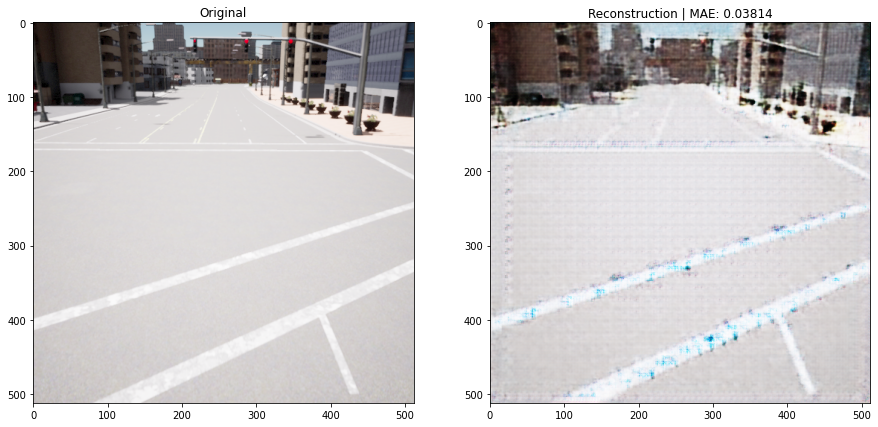

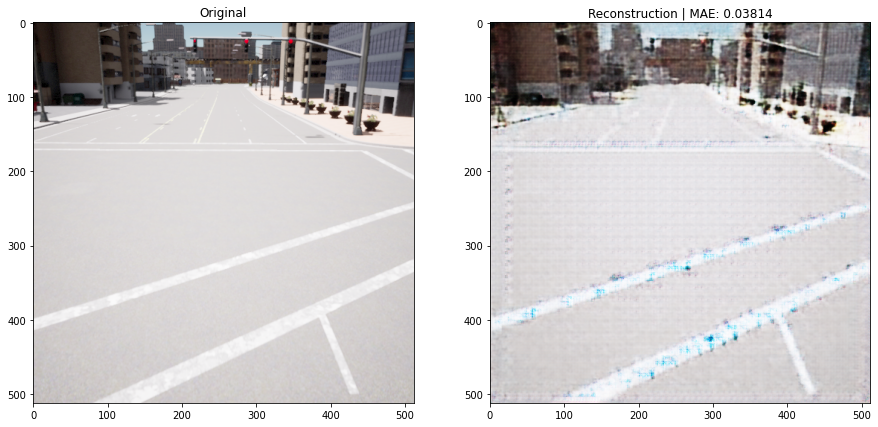

In [18]:
import random

def make_prediction(dataSet, index):
    model.eval()
    with torch.no_grad():
        imgs = torch.as_tensor(np.array([dataSet[index]]))
        imgs = np.transpose(imgs, (0,3,2,1))
        imgs = imgs.to(device)
    #         img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        true_img = imgs[0].cpu().numpy()
        true_img = np.transpose(true_img, (2,1,0))

        out = model(imgs)
    #         outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        out = out[0].cpu().numpy()
        out = np.transpose(out, (2,1,0))
        errorMatrix = np.absolute(true_img - out)
        errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1] * errorMatrix.shape[2])
        errorAvg = int(errorAvg * 100000)/ 100000.0

        #plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        ax1.set_title("Original")
        ax1.imshow(true_img)
        ax2.set_title(f"Reconstruction | MAE: {errorAvg}")
        ax2.imshow(out)
        return fig
    
make_prediction(test_data, 0)